In [4]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Code 2.1

In [2]:
ways = np.array([0, 3, 8, 9, 0])
ways / ways.sum()

array([0.  , 0.15, 0.4 , 0.45, 0.  ])

#### Code 2.2

$$Pr(w \mid n, p) =  \frac{n!}{w!(n − w)!} p^w (1 − p)^{n−w}$$

$$Pr(W, L \mid p) =  \frac{(L+W)!}{W!(L)!} p^W (1 − p)^{L}$$


The probability of observing six W’s in nine tosses—under a value of p=0.5

In [12]:
stats.binom.pmf(6, n=9, p=0.5)

0.16406250000000006

#### Code 2.3 and 2.5

Computing the posterior using a grid approximation.

In the book the following code is not inside a function, but this way is easier to play with different parameters

In [37]:
def posterior_grid_approx(grid_points=5, success=6, tosses=9, prior='uniform',
                         lower_limit=.5, center=.5):
    """
    prior can be uniform, truncated (takes arg lower_limit, or double_exp (arg center)
    returns grid, posterior
    
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    if prior == 'uniform':
        prior = np.repeat(5, grid_points)  # uniform
    if prior == 'truncated':
        prior = (p_grid >= lower_limit).astype(int)  # truncated
    if prior == 'double_exp':
        prior = np.exp(- 5 * abs(p_grid - center))  # double exp

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior


#### Code 2.3

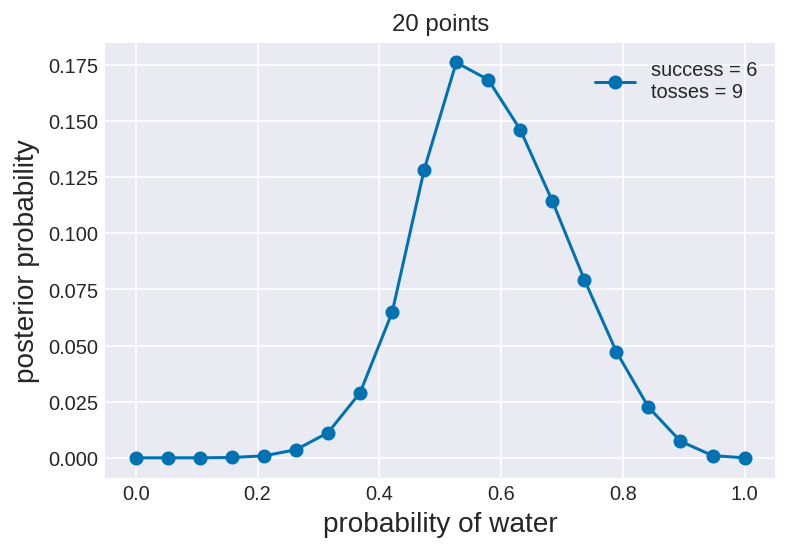

In [7]:
points = 20
w, n = 6, 9
p_grid, posterior = posterior_grid_approx(points, w, n)
plt.plot(p_grid, posterior, 'o-', label='success = {}\ntosses = {}'.format(w, n))
plt.xlabel('probability of water', fontsize=14)
plt.ylabel('posterior probability', fontsize=14)
plt.title('{} points'.format(points))
plt.legend(loc=0);

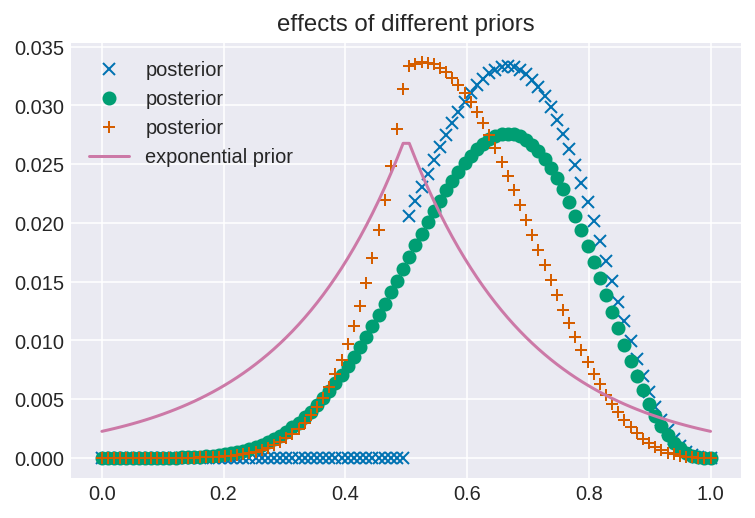

In [43]:
# play around with different parameters, like different priors,
# also pulled outside of function for beginner programmers to easily
# see what is doing what. 
points = 100
p_grid = np.linspace(0, 1, points)
successes = 6
tosses = 9


likelihood = stats.binom.pmf(successes, tosses, p_grid)

prior = (p_grid >= 0.5).astype(int)
posterior = likelihood * prior
plt.plot(p_grid, posterior/posterior.sum(), 'x',label= 'posterior')

prior = np.repeat(1,points)
posterior = likelihood * prior
plt.plot(p_grid, posterior/posterior.sum(), 'o', label='posterior')

prior = np.exp(-5 * abs(p_grid - 0.5))
posterior = likelihood * prior
plt.plot(p_grid, posterior/posterior.sum(), '+',label = 'posterior')



plt.plot(p_grid, prior/prior.sum(), label = 'exponential prior')
plt.legend()
plt.title('effects of different priors')
plt.show()


#### Code 2.6

Computing the posterior using the quadratic aproximation

In [5]:
data = np.repeat((0, 1), (3, 6))
with pm.Model() as normal_aproximation:
    p = pm.Uniform('p', 0, 1)
    w = pm.Binomial('w', n=len(data), p=p, observed=data.sum())
    mean_q = pm.find_MAP()
    std_q = ((1/pm.find_hessian(mean_q, vars=[p]))**0.5)[0]
mean_q['p'], std_q

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -1.8075, ||grad|| = 1.5: 100%|██████████| 7/7 [00:00<00:00, 1741.72it/s]
/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
/home/brian/anaconda2/envs/py36/lib/python3.6/site-packag

(array(0.66666667), array([0.15713484]))

In [6]:
norm = stats.norm(mean_q, std_q)
prob = .89
z = stats.norm.ppf([(1-prob)/2, (1+prob)/2])
pi = mean_q['p'] + std_q * z 
pi

array([0.41553484, 0.91779849])

#### Code 2.7

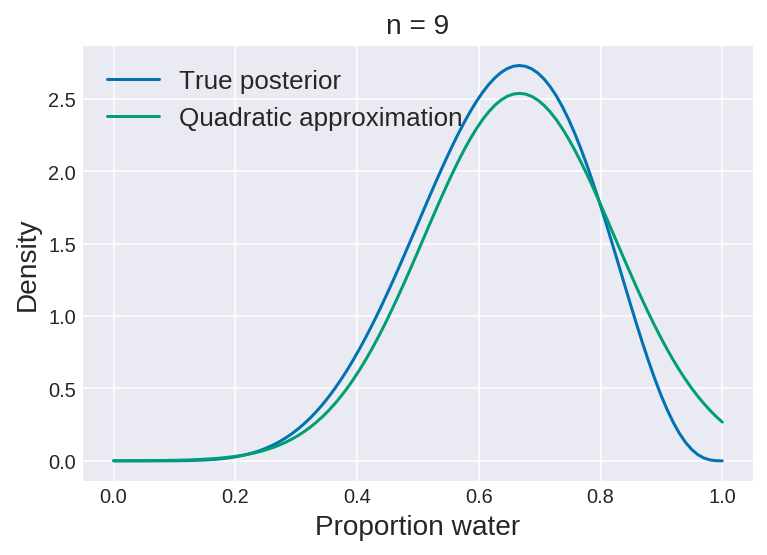

In [7]:
# analytical calculation
w, n = 6, 9
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x , w+1, n-w+1),
         label='True posterior')

# quadratic approximation
plt.plot(x, stats.norm.pdf(x, mean_q['p'], std_q),
         label='Quadratic approximation')
plt.legend(loc=0, fontsize=13)

plt.title('n = {}'.format(n), fontsize=14)
plt.xlabel('Proportion water', fontsize=14)
plt.ylabel('Density', fontsize=14);

In [9]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__))

This notebook was createad on a computer x86_64 running debian stretch/sid and using:
Python 3.6.3
IPython 6.3.1
PyMC3 3.4.1
NumPy 1.14.2
SciPy 1.0.1
Matplotlib 2.2.2



### Problems:

1. Your friend has fabricated a loaded die. In doing so, he has chosen at random one of the
values 0.1, 0.2, 0.3, or 0.4 and has loaded the die in such a way that any roll of the die results
in the outcome 6 with probability equal to the randomly chosen value. He does not tell you
what the chosen value is. You ask him to roll the die 300 times and to inform you how often
the outcome 6 has appeared. He tells you that the outcome 6 appeared 75 times. What is
the posterior distribution of the probability of a 6?

Method of attack: set a uniform prior over possible values, then update with likelihood based on data from rolls given my prior through bayes theorem.

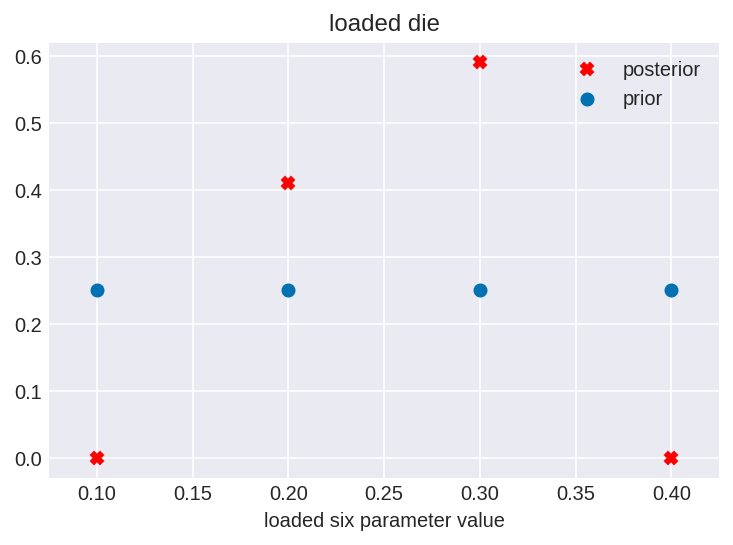

In [50]:
p_grid = np.array([.1,.2,.3,.4]) # possible parameter values for six,

prior = np.array([1,1,1,1]) # uniform
 #75/300 appeard 
    
    
likelihood = stats.binom.pmf(75, 300, p_grid)

post = likelihood * prior
posterior = post/post.sum()


plt.scatter(p_grid, prior/prior.sum(), label='prior')
#plt.scatter(p_grid, likelihood, label='likelihood')
plt.plot(p_grid, posterior, 'X', color='red',label='posterior')

plt.xlabel('loaded six parameter value')
plt.title('loaded die')
plt.legend()
plt.show()


The maximum posterior parameter value is is 3/10. That is, it is most likely he loaded the die such that six would come up 3/10 instead of the fair 1/6 -- Thats a really heavy loading! There is a very low chance of either 1/10 or 4/10, intuitively this is becaues there were enough rolls (300) to have high confidence in the binomial(either a six or not) likelihood and that 1/10 and 4/10 would be very unlikely given 75/300 resulted in a six. That is to say, with the same die achieving on average a 30/300 or better yet a 300/3000 is much less likely than say 90/300 or 900/3000. Or arguably more simply stated as a proportion of 3/10 has a 6/10 chance of being the loaded chance of rolling a six. Another way of stating this is that given the info you recieved to be trustworthy you are ~60% confident that loaded six parameter is .3 and ~40% confident that the parameter is .2.

If we increase the number of success and rolls in the same proportion say, 750/3000 we become 97% confident the loaded parameter is .3. More data, more confident. 


In [40]:
posterior

array([5.28453388e-113, 2.52538693e-002, 9.74746131e-001, 1.15522694e-057])

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  
/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  app.launch_new_instance()


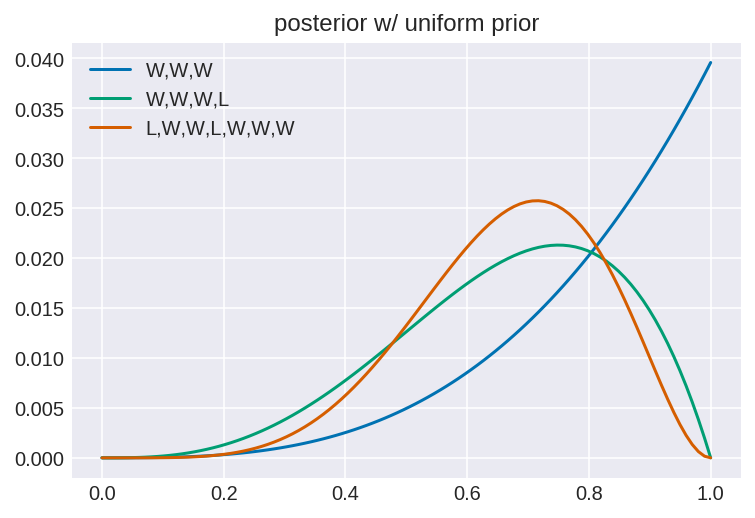

In [39]:
n_outcomes = 3
outcomes = ('W,W,W'),('W,W,W,L'),('L,W,W,L,W,W,W')
successes = [3,3,5]
tosses = [3,4,7]


for i in range(n_outcomes):
    grid,post= posterior_grid_approx(grid_points=100, success = successes[i],
                                     tosses = tosses[i])
    plt.plot(grid,post, label = outcomes[i])
plt.legend()
plt.title('posterior w/ uniform prior')
plt.show()


##### 2M2

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  app.launch_new_instance()


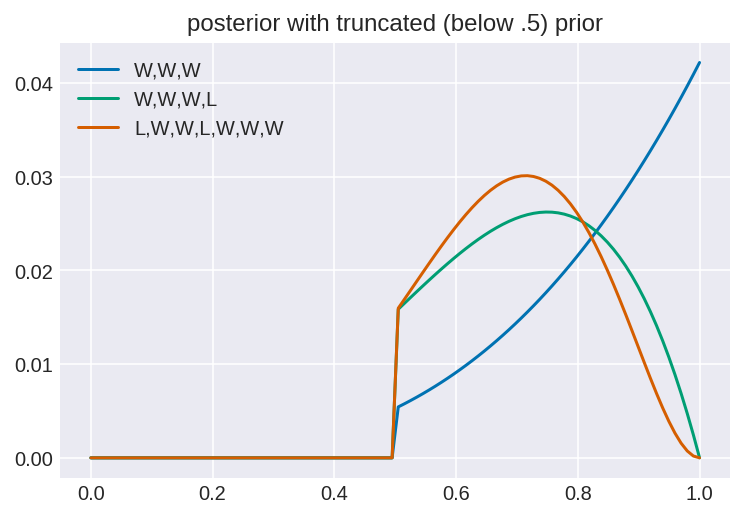

In [40]:
n_outcomes = 3
outcomes = ('W,W,W'),('W,W,W,L'),('L,W,W,L,W,W,W')
successes = [3,3,5]
tosses = [3,4,7]


for i in range(n_outcomes):
    grid,post= posterior_grid_approx(grid_points=100, success = successes[i],
                                     tosses = tosses[i], prior = 'truncated', lower_limit=.5)
    plt.plot(grid,post, label = outcomes[i])
plt.legend()
plt.title('posterior with truncated (below .5) prior')
plt.show()

#### 2M3

$$Pr(E \mid L)Pr(L) = Pr(L \mid E)Pr(E) $$


$$Pr(E \mid L) = \frac{Pr(L \mid E)Pr(E)}{Pr(L)} $$


$$Pr(E \mid L) = \frac{Pr(L \mid E)Pr(E)}{Pr(L\mid E)Pr(E) + Pr(L \mid M)Pr(M)} $$



In [42]:
P_LgivenE = .3
P_E = .5

P_LgivenM = 1.
P_M = .5

unstd_post = P_LgivenE*P_E
post = unstd_post/(unstd_post + P_LgivenM*P_M)
print ('The posterior probability:\n', np.round(post,3))

The posterior probability:
 0.231


The rest of 2M on paper.
#### 2H1

In [45]:
# P(twins 2nd | twins 1st)
.2*2./3. + 1./3.*.1

0.16666666666666666

#### 2H2

on paper

#### 2H3

In [54]:

# P(A|twins 1st, single 2nd)

prob_birth = .9*1/3/(.9*1/3 + .8*2/3)
print ('Probability species A given birth data: \n', np.round(prob_birth, 3))

Probability species A given birth data: 
 0.36


#### 2H4

In [67]:
# part A
prior = .5
likelihood = .8
prob_testA = prior*likelihood + .35*(1-prior)

posterior = prior * likelihood / (prob_testA)
print ('posterior with just test data and flat prior: \n', np.round(posterior,3))

posterior with just test data and flat prior: 
 0.696


In [66]:
#part B, assimilate data
# plan: use birth posterior as new prior
# probability panda is species A, given prior birth knowledge and new test data

prior = prob_birth
likelihood = .8 # from book P correctly identifying species A, (i.e. P(test_A|A))
prob_testA = prior*likelihood + .35*(1-prior) # P(test_A|A)P(A) + P(test_A|B)*P(B)

posterior = prior * likelihood / (prob_testA)
print ('updated posterior given both birth data and test: \n', np.round(posterior,3))

updated posterior given both birth data and test: 
 0.562
